In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
from src.video_processor import VideoProcessor

In [2]:
input_video_file = os.path.join(os.getcwd(), 'data', '2024_02_20_RPi1_1Did_starved_1.mp4')
bg_transparent_video_file = input_video_file.replace('.mp4', '_bg_transparent.mp4')
detections_file = input_video_file.replace('.mp4', '_detections.csv')
max_projection_image = input_video_file.replace('.mp4', '_projection.png')
sampling_chamber_info_file =  input_video_file.replace('.mp4', '_sampling_chamber_info.pkl')
output_video_file = input_video_file.replace('.mp4', '_out_video.mp4')
track_file = input_video_file.replace('.mp4', '_track.csv')

In [3]:
vp = VideoProcessor()

In [4]:
cap = cv2.VideoCapture(input_video_file)
_, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cap.release()

sampling_chamber = vp.compute_sampling_chamber_from_user_input(frame=frame)

In [25]:
vp.save_sampling_chamber_info(sampling_chamber_info=sampling_chamber, output_file_path=sampling_chamber_info_file)

sampling_chamber = vp.load_sampling_chamber_info(sampling_chamber_info_file)

In [6]:
# vp.bg_sliding_window(input_video_path=input_video_file, output_video_path=bg_transparent_video_file)
# vp.bg_subtraction_downsampling(input_video_path=input_video_file, output_video_path=bg_transparent_video_file, downsampling_factor=100)
vp.memory_efficient_bg_removal(input_video_path=input_video_file, output_video_path=bg_transparent_video_file, window_size=900, filter=True)

In [7]:
vp.filter_outside_sampling_chamber(input_video_path=bg_transparent_video_file, output_video_path=output_video_file, sampling_chamber_info=sampling_chamber, k=1.2, fps=30)

In [4]:
max_projection = vp.max_projection(input_video_path=bg_transparent_video_file)

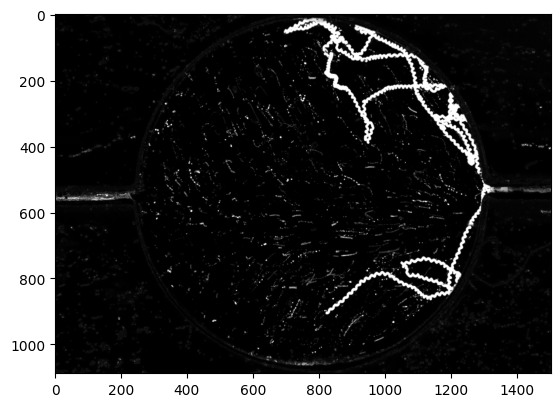

In [5]:
cv2.imwrite(max_projection_image, np.uint8(max_projection))

plt.imshow(max_projection, cmap='gray', vmin=0, vmax=255)
plt.show()

In [10]:
vp.run_detections(input_video_path=output_video_file, detections_file_path=detections_file)

In [11]:
detections = pd.read_csv(detections_file)

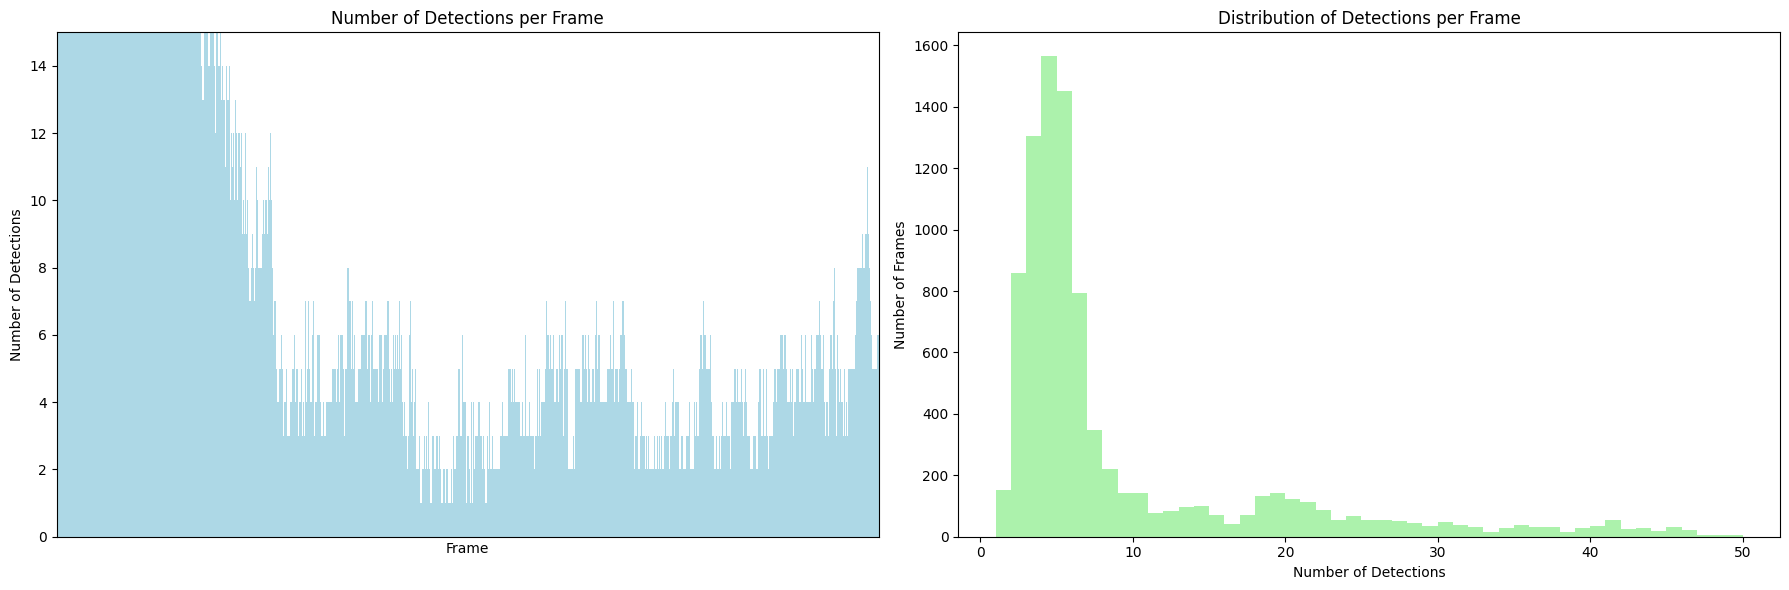

In [12]:
fig = vp.plot_detections_per_frame(detections)
plt.show()

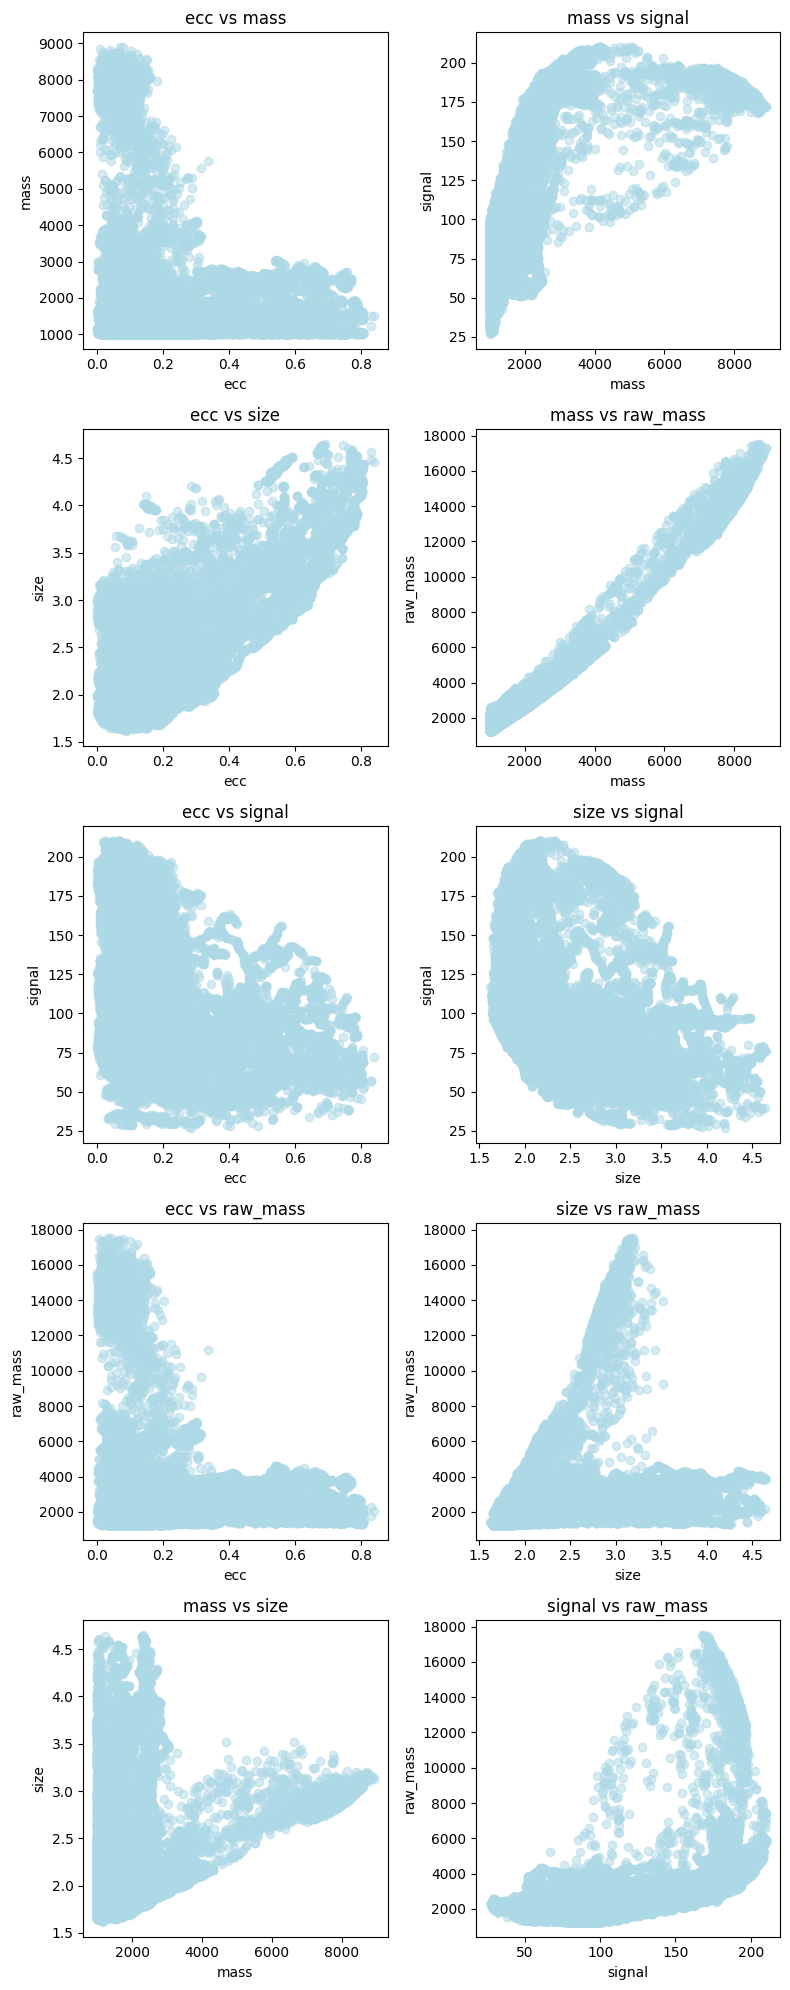

In [13]:
fig = vp.plot_detection_features(detections)
plt.show()

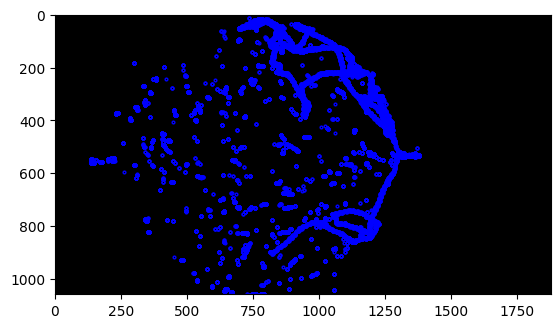

In [14]:
fig = vp.detections_projection(width=1880, height=1060, detections=detections)

/home/ekin/LPL/CellTrajectories/src/video_processor.py:362: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_detections = filtered_detections[detections[col] > threshold]


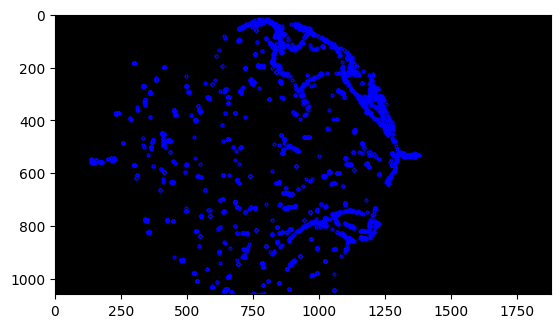

In [15]:
filters = { 'ecc': {'threshold': 0.4, 'operation': 'lower'},     
            'mass': {'threshold': 3000, 'operation': 'higher'}} 
filtered_detections = vp.filter_detections(detections=detections, filters=filters)
fig = vp.detections_projection(width=1880, height=1060, detections=filtered_detections)

In [16]:
tracks_df = vp.track_cells(detections=detections, cell_config_file=os.path.join(os.getcwd(), 'config', 'cell_config.json'))

[INFO][2024/04/25 07:38:31 PM] Loaded btrack: /home/ekin/LPL/CellTrajectories/venv/lib/python3.9/site-packages/btrack/libs/libtracker.so
[INFO][2024/04/25 07:38:31 PM] Starting BayesianTracker session
[INFO][2024/04/25 07:38:31 PM] Loading configuration file: /home/ekin/LPL/CellTrajectories/config/cell_config.json
[INFO][2024/04/25 07:38:31 PM] Objects are of type: <class 'list'>
[INFO][2024/04/25 07:38:32 PM] Starting tracking... 
[INFO][2024/04/25 07:38:32 PM] Update using: ['MOTION']
[INFO][2024/04/25 07:38:32 PM] Tracking objects in frames 0 to 99 (of 9006)...
[INFO][2024/04/25 07:38:32 PM]  - Timing (Bayesian updates: 0.29ms, Linking: 0.08ms)
[INFO][2024/04/25 07:38:32 PM]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2024/04/25 07:38:32 PM]  - Stats (Active: 46, Lost: 256, Conflicts resolved: 40)
[INFO][2024/04/25 07:38:32 PM] Tracking objects in frames 100 to 199 (of 9006)...
[INFO][2024/04/25 07:38:32 PM]  - Timing (Bayesian updates: 0.25ms, Linking: 0.07ms)
[INFO][202

GLPK Integer Optimizer 5.0
5300 rows, 4856 columns, 10686 non-zeros
4856 integer variables, all of which are binary
Preprocessing...
464 rows, 1550 columns, 3193 non-zeros
1550 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 464
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
464 rows, 1550 columns, 3193 non-zeros
*     0: obj =   9.072029444e+04 inf =   0.000e+00 (945)
*   528: obj =   8.824904645e+04 inf =   0.000e+00 (0) 1
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+   528: mip =     not found yet >=              -inf        (1; 0)
+   536: >>>>>   8.825210102e+04 >=   8.824936657e+04 < 0.1% (3; 0)
+   542: >>>>>   8.825099743e+04 >=   8.825099743e+04   0.0% (1; 2)
+   542: mip =   8.825099743e+04 >=     tree is empty   0.0% (0; 5)
INTEGER OPTIMAL SOLUTION FOUND


In [17]:
tracks_df.head()

,ID,t,x,y,z,parent,root,state,generation,dummy,mass,ecc,size,raw_mass,signal
0,36,0,257.722396,485.878125,0.0,36,36,5,0,False,1466.206053,0.089638,2.319191,2921.0,101.565315
1,36,1,257.699221,485.879481,0.0,36,36,5,0,False,1470.711872,0.087633,2.320210,2958.0,100.084808
2,36,2,257.697286,485.889353,0.0,36,36,5,0,False,1470.773866,0.088105,2.324194,2960.0,100.559173
3,36,3,257.705122,485.862258,0.0,36,36,5,0,False,1513.954753,0.094540,2.337509,2907.0,102.385801
4,36,4,257.699324,485.851834,0.0,36,36,5,0,False,1548.680813,0.101752,2.332000,2819.0,102.398297


In [18]:
connected_tracks = vp.connect_tracks(tracks=tracks_df)

In [19]:
connected_tracks.head()

,ID,t,x,y,z,parent,root,state,generation,dummy,mass,ecc,size,raw_mass,signal
0,36,0,257.722396,485.878125,0.0,36,36,5,0,False,1466.206053,0.089638,2.319191,2921.0,101.565315
1,36,1,257.699221,485.879481,0.0,36,36,5,0,False,1470.711872,0.087633,2.320210,2958.0,100.084808
2,36,2,257.697286,485.889353,0.0,36,36,5,0,False,1470.773866,0.088105,2.324194,2960.0,100.559173
3,36,3,257.705122,485.862258,0.0,36,36,5,0,False,1513.954753,0.094540,2.337509,2907.0,102.385801
4,36,4,257.699324,485.851834,0.0,36,36,5,0,False,1548.680813,0.101752,2.332000,2819.0,102.398297


In [20]:
tracks_filtered = vp.filter_tracks(tracks=connected_tracks, min_track_length=6000, min_convex_hull_covered=100)

In [21]:
tracks_filtered.head()

,ID,t,x,y,z,parent,root,state,generation,dummy,mass,ecc,size,raw_mass,signal
14542,1,0,1067.796094,913.211897,0.000000,1,1,5,0,False,2580.369924,0.062499,1.871975,3352.0,186.330353
14543,1,1,1067.703679,913.255913,0.000000,1,1,5,0,False,2325.634773,0.071866,1.838860,3011.0,175.721418
14544,1,2,1067.613936,913.298588,-0.000047,1,1,5,0,True,NaN,NaN,NaN,NaN,NaN
14545,1,3,1067.524193,913.341262,-0.000094,1,1,5,0,True,NaN,NaN,NaN,NaN,NaN
14546,1,4,1067.434450,913.383937,-0.000141,1,1,5,0,True,NaN,NaN,NaN,NaN,NaN


In [22]:
np.unique(tracks_filtered['ID'].values)

array([1])

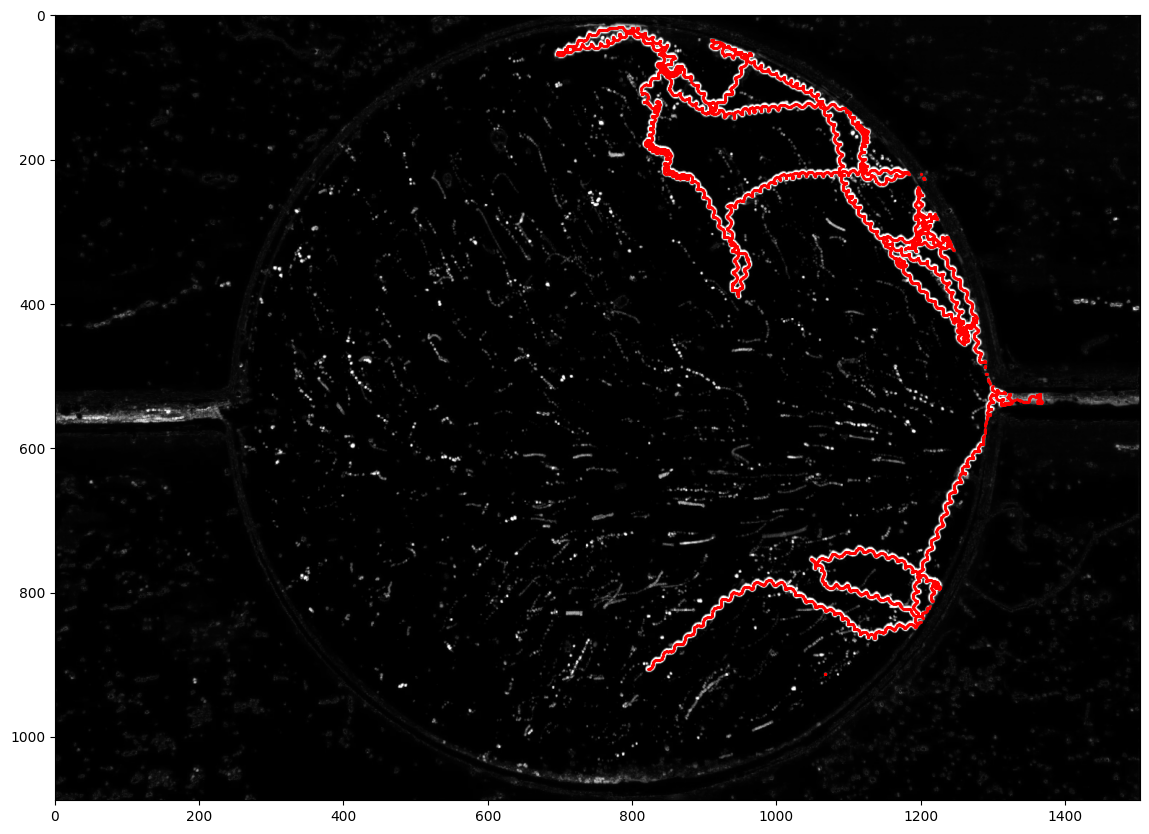

In [23]:
fig = vp.plot_track_on_frame(max_projection, tracks_filtered[tracks_filtered['ID'] == 1])

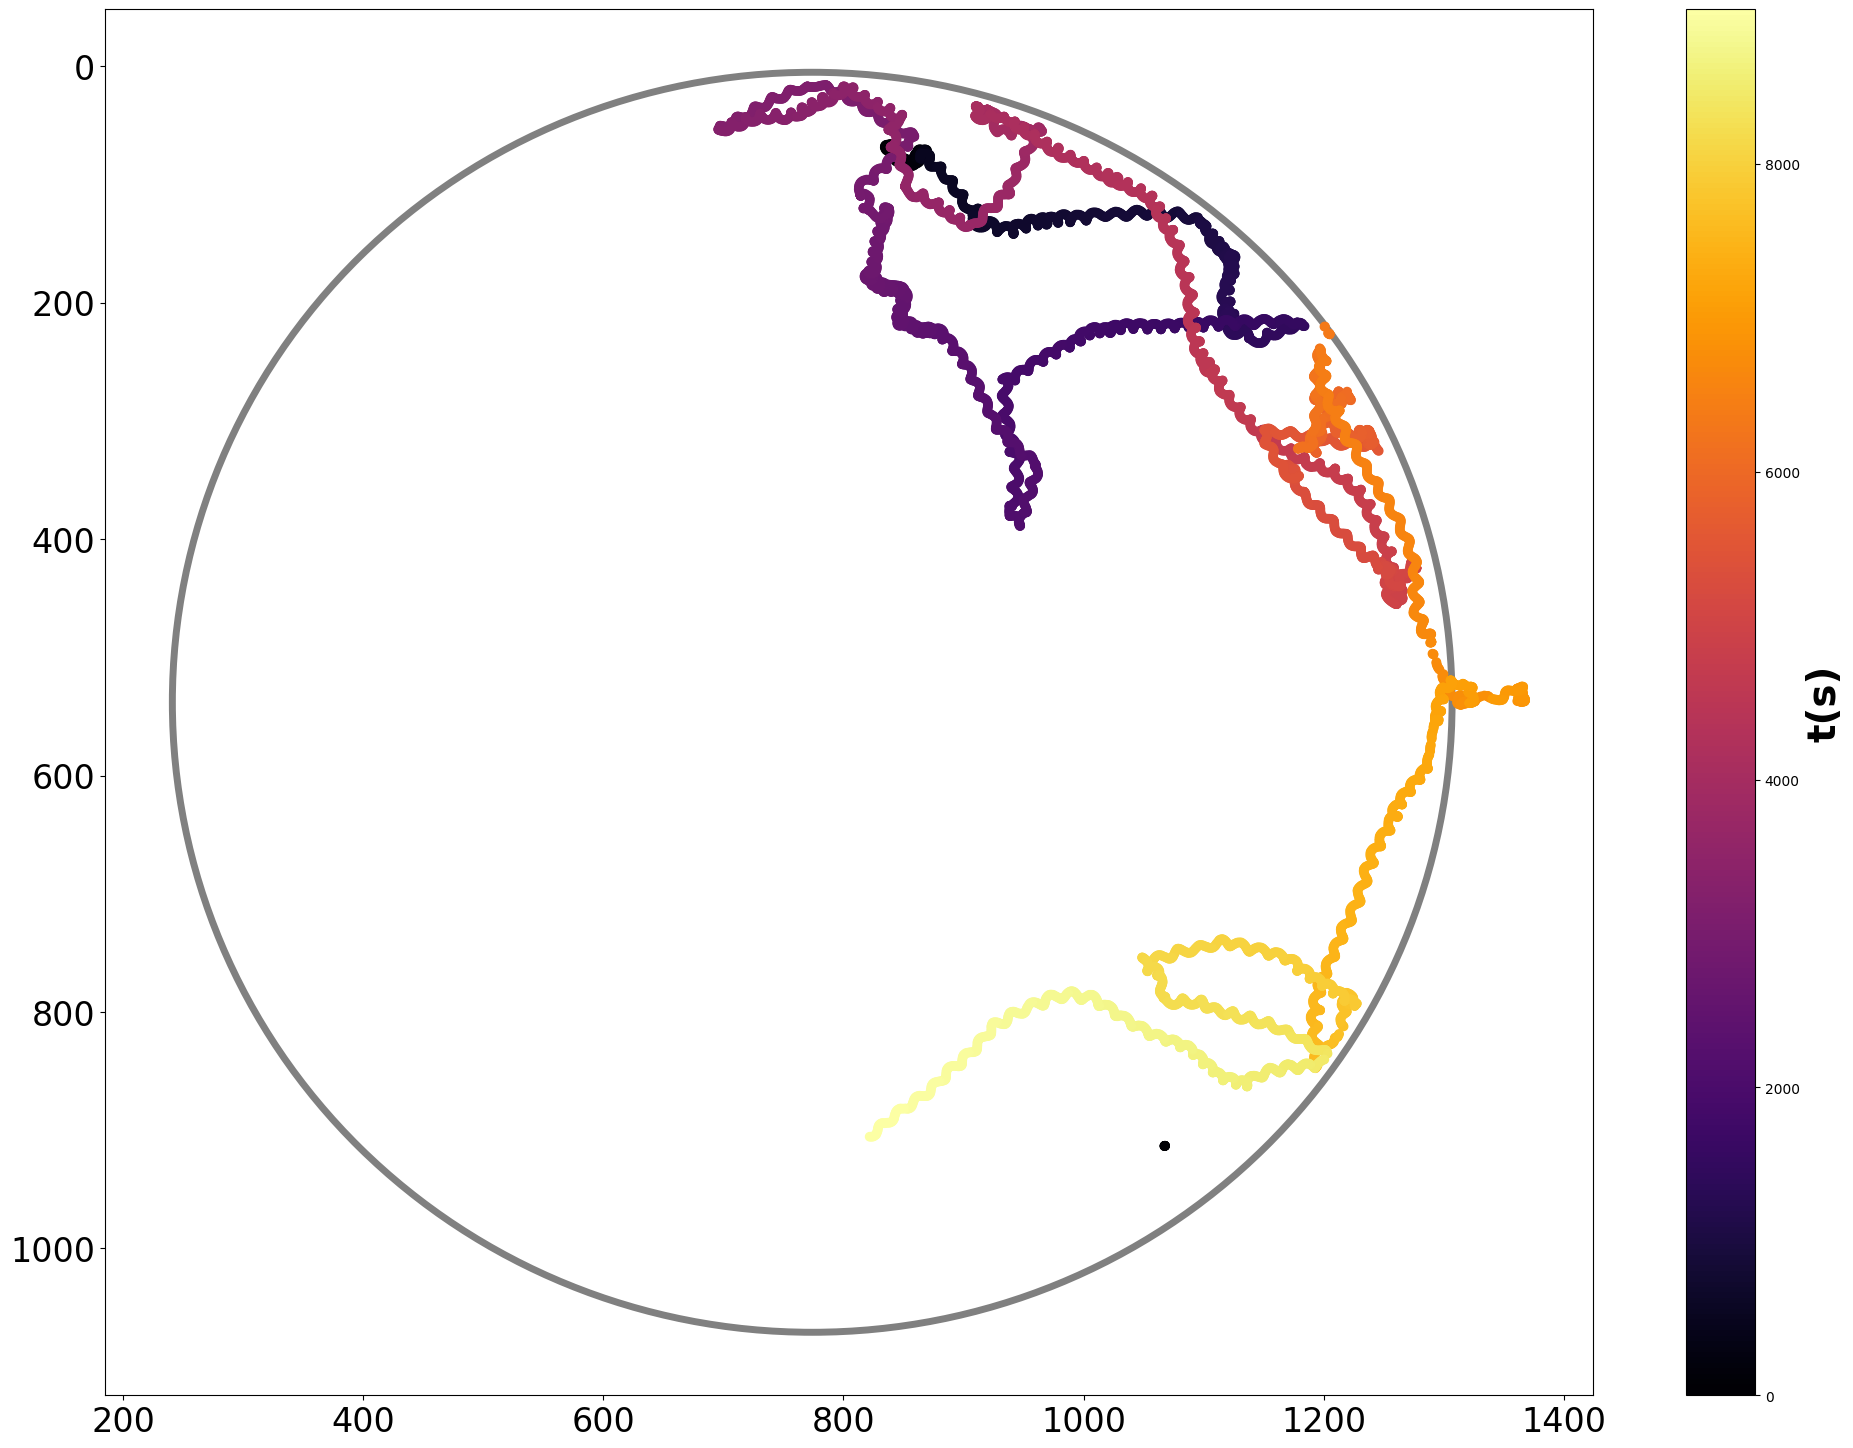

In [26]:
fig = vp.plot_track(tracks_filtered[tracks_filtered['ID'] == 1], sampling_chamber)

In [ ]:
tracks_filtered[tracks_filtered['ID'] == 1].to_csv(track_file)